### Introduction

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import math

In [2]:
data_dir = "malaria/cell_images"
data_dir = os.path.join(os.getcwd(), data_dir)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='binary', batch_size=32)

Found 27558 files belonging to 2 classes.


In [4]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_HEIGHT, IMG_WIDTH)

infected_img = []
healthy_img = []

for filename in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, filename)):
        path = os.path.join(data_dir, filename)
        path = os.path.join(path, file)
        
        if path.endswith(".png"):

            # load the image
            img = tf.keras.preprocessing.image.load_img(
                path, target_size = target_size)

            # report details about the image
            # print(type(img))
            # print(img.format)
            # print(img.mode)
            # print(img.size)

            # show the image
            # img.show()

            # convert to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            # print(img_array.dtype)
            # print(img_array.shape)

            # convert numpy array back to image
            # img_pil = tf.keras.preprocessing.image.array_to_img(img_array)
            # print(type(img_pil))

            # show the image
            # plt.imshow(img_array.astype(np.uint8))

            if filename == "Parasitized":
                infected_img.append(img_array)
            else:
                healthy_img.append(img_array)
        else:
            continue

In [5]:
# Turn list of arrays into one array. 
images_healthy = np.stack(healthy_img, axis = 0)
labels_healthy = np.zeros((1, images_healthy.shape[0]))
images_infected = np.stack(infected_img, axis = 0)
labels_infected = np.ones((1, images_infected.shape[0]))

In [6]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy.shape))
print("Shape of healthy label array: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected.shape))
print("Shape of infected label array: " + str(labels_healthy.shape))
print("Shape of an image: " + str(images_healthy[0].shape))

Shape of healthy image array: (13779, 32, 32, 3)
Shape of healthy label array: (1, 13779)
Shape of infected image array: (13779, 32, 32, 3)
Shape of infected label array: (1, 13779)
Shape of an image: (32, 32, 3)


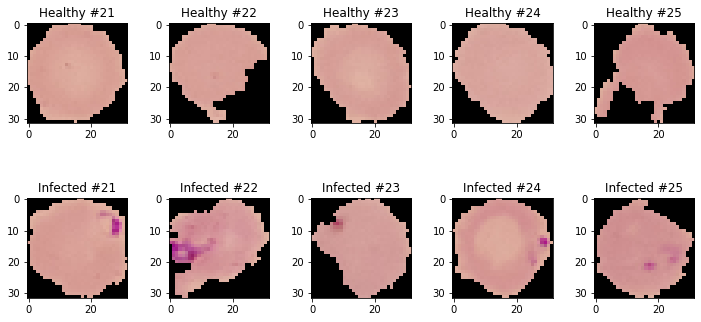

In [10]:
rows = 2
columns = 5
ind_healthy = 20
ind_infected = 20
f, axs = plt.subplots(rows, columns, figsize=(10, 5))
f.tight_layout()
for i in range(columns):
    axs[0, i].imshow(healthy_img[ind_healthy+i].astype(np.uint8))
    axs[0, i].set_title("Healthy #"+str(i+1 + ind_healthy))
for i in range(columns):
    axs[1, i].imshow(infected_img[ind_infected+i].astype(np.uint8))
    axs[1, i].set_title("Infected #"+str(i+1 + ind_infected))

In [11]:
# Flatten each image into array of (IMG_HEIGHT * IMG_WIDTH * channel, m), where `m` is number of examples. 
def flatten(image_array):
    '''
    Takes as input image that has been converted to numpy array. 
    Outputs flatted version of the numpy array of shape (IMG_HEIGHT * IMG_WIDTH * channel, m), 
    where `m` stands for number of examples. 
    '''
    flat_img_array = np.reshape(image_array, (IMG_HEIGHT * IMG_WIDTH * image_array.shape[-1], -1))
    return flat_img_array

In [12]:
# Flatten the images
images_healthy_flat = flatten(images_healthy)
images_infected_flat = flatten(images_infected)

# Standardize the data to have value between 0...1
images_healthy_flat /= 255.
images_infected_flat /= 255.

In [13]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy_flat.shape))
print("Shape of healthy images labels: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected_flat.shape))
print("Shape of infected images labels: " + str(labels_infected.shape))

Shape of healthy image array: (3072, 13779)
Shape of healthy images labels: (1, 13779)
Shape of infected image array: (3072, 13779)
Shape of infected images labels: (1, 13779)


In [14]:
# Shuffle healthy image and infected image array + labels (shuffling labels for training purposes only). 
# Divide them into training, dev and test set. 
from sklearn.utils import shuffle
ind1 = shuffle(np.arange(images_healthy_flat.shape[1]))
images_healthy_shuffled = images_healthy_flat[:, ind1]
labels_healthy_shuffled = labels_healthy[:, ind1]

ind2 = shuffle(np.arange(images_infected_flat.shape[1]))
images_infected_shuffled = images_infected_flat[:, ind2]
labels_infected_shuffled = labels_infected[:, ind2]

In [15]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy_flat.shape))
print("Shape of healthy images labels: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected_flat.shape))
print("Shape of infected images labels: " + str(labels_infected.shape))

index = 100
print(np.array_equal(images_healthy_flat[index], images_healthy_shuffled[index]))   # must be False
print(np.array_equal(images_infected_flat[index], images_infected_shuffled[index])) # must be False
print(np.array_equal(images_healthy_flat[index], images_healthy_flat[index]))       # must be True

Shape of healthy image array: (3072, 13779)
Shape of healthy images labels: (1, 13779)
Shape of infected image array: (3072, 13779)
Shape of infected images labels: (1, 13779)
False
False
True


In [16]:
# Create a train, dev and test set. [train / dev/ test]  = [20,002 / 3,778 / 3,778]
X_train_orig = np.concatenate((images_healthy_shuffled[:, : 10001], images_infected_shuffled[:, : 10001]), axis=1)
y_train_orig = np.concatenate((labels_healthy_shuffled[:, : 10001], labels_infected_shuffled[:, : 10001]), axis=1)

X_dev_orig = np.concatenate((images_healthy_shuffled[:, 10001 : 11890], images_infected_shuffled[:, 10001 : 11890]), axis=1)
y_dev_orig = np.concatenate((labels_healthy_shuffled[:, 10001 : 11890], labels_infected_shuffled[:, 10001 : 11890]), axis=1)

X_test_orig = np.concatenate((images_healthy_shuffled[:, 11890 : ], images_infected_shuffled[:, 11890 : ]), axis = 1)
y_test_orig = np.concatenate((labels_healthy_shuffled[:, 11890 : ], labels_infected_shuffled[:, 11890 : ]), axis = 1)

In [17]:
# Sanity check
print("Shape of X_train_orig: " + str(X_train_orig.shape))
print("Shape of y_train_orig: " + str(y_train_orig.shape))
print("Shape of X_dev_orig: " + str(X_dev_orig.shape))
print("Shape of y_dev_orig: " + str(y_dev_orig.shape))
print("Shape of X_test_orig: " + str(X_dev_orig.shape))
print("Shape of y_test_orig: " + str(y_test_orig.shape))

Shape of X_train_orig: (3072, 20002)
Shape of y_train_orig: (1, 20002)
Shape of X_dev_orig: (3072, 3778)
Shape of y_dev_orig: (1, 3778)
Shape of X_test_orig: (3072, 3778)
Shape of y_test_orig: (1, 3778)


In [18]:
# Shuffle training, dev and test set. 
ind1 = shuffle(np.arange(X_train_orig.shape[1]))
X_train = X_train_orig[:, ind1]
y_train = y_train_orig[:, ind1]

ind2 = shuffle(np.arange(X_dev_orig.shape[1]))
X_dev = X_dev_orig[:, ind2]
y_dev = y_dev_orig[:, ind2]

ind3 = shuffle(np.arange(X_test_orig.shape[1]))
X_test = X_test_orig[:, ind3]
y_test = y_test_orig[:, ind3]

In [19]:
# Sanity check
print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(y_train.shape))
print("Shape of X_dev: " + str(X_dev.shape))
print("Shape of y_dev: " + str(y_dev.shape))
print("Shape of X_test: " + str(X_dev.shape))
print("Shape of y_test: " + str(y_test.shape))

Shape of X_train: (3072, 20002)
Shape of y_train: (1, 20002)
Shape of X_dev: (3072, 3778)
Shape of y_dev: (1, 3778)
Shape of X_test: (3072, 3778)
Shape of y_test: (1, 3778)


First, lets start with the simple logistic regression model. 
It will allow us to get some baseline upon which we can improve. 
Our network will consist of 2 layers in total - one for the input and 1 for the output.
Input will consist of 12 288 units and output of just one. 

In [ ]:
def initialize_parameters(n_x, n_y):
    '''
    Initialize the parameters `w` and `b` for the simple logistic regression model. 
    
    `w` - weight
    `b` - bias
    '''
    w = np.random.randn(n_x, n_y) * np.sqrt(2/n_x)
    b = np.zeros((1, n_y))
    return w, b

In [34]:
def sigmoid(x):
    '''
    Calculate sigmoid function of x. 
    '''
    s = 1 / (1 + np.exp(-x))
    return s

In [ ]:
def forward_propagation(X, w, b):
    '''
    Compute forward propagation
    '''
    z = np.dot(w.T, X) + b
    a = sigmoid(z)
    
    return a

In [ ]:
def cost_calculation(A, Y):
    '''
    Calculate cost of given A, Y.
    
    `A` - prediction made by the sigmoid function
    `Y` - actual value
    '''
    m = Y.shape[1]
    J = (-1 / m) * (np.dot(Y, np.log(A.T)) + np.dot((1-Y), np.log(1-A.T)))
    return J

In [ ]:
def backward_propagation(X, Y, A):
    '''
    Performs backward propagation. Returns `dw` and `db`. 
    '''
    # Number of examples
    m = X.shape[1]
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    return dw, db

In [ ]:
def update_parameters(w, b, dw, db, learning_rate):
    w = w - learning_rate * dw
    b = b - learning_rate * db
    return w, b

In [ ]:
def predict(X, w, b):
    '''
    Returns accuracy for the train and dev set. 
    '''
    m = X.shape[1]
    y_predict = np.zeros((1, m))
    a = forward_propagation(X, w, b)
    np.place(y_predict, a>=0.5, 1)
    return y_predict

In [ ]:
def model(X_train, y_train, X_dev, y_dev, learning_rate = 0.001, epochs = 10):
    '''
    Quite cool if I would have time for mini-batch implementation aswell. Check how does the cost change in time. 
    '''
    
    cost_train = []
    cost_dev = []
    n_x = X_train.shape[0]
    n_y = y_train.shape[0]
    
    # Initialize parameters `w` and `b`.
    w, b = initialize_parameters(n_x, n_y)
    
    for i in range(epochs):

        # Perform forward propagation
        a_train = forward_propagation(X_train, w, b)
        a_dev = forward_propagation(X_dev, w, b)

        # Calculate cost
        J_train  = cost_calculation(a_train, y_train)
        cost_train.append(J_train[0][0])
        J_dev = cost_calculation(a_dev, y_dev)
        cost_dev.append(J_dev[0][0])
        
        # Perform backward propagation
        dw, db = backward_propagation(X_train, y_train, a_train)

        # Update parameters `w` and `b`. 
        w, b = update_parameters(w, b, dw, db, learning_rate)
        
        # Print epoch number and cost function at every 5th iteration.
        if (i + 1) % 5 == 0 or i == 0:
            print("Cost after iteration {}: {:.3f}".format(i + 1, cost_train[-1]))
            
        if i == epochs-1:
            print("Finished training.", end='\n')
    
    # Visualise the cost function 
    plt.plot(list(range(1,len(cost_train)+1)), cost_train, label='Training cost')
    plt.plot(list(range(1, len(cost_dev)+1)), cost_dev, label="Dev cost")
    plt.legend()

    
    # Calculate accuracy on the training set.
    y_train_predict = predict(X_train, w, b)
    print("Accuracy on the training set: {:.2f}%".format(100 - np.mean(np.abs(y_train_predict - y_train)) * 100))
    
    # Calculate accuracy on dev set. 
    y_dev_predict = predict(X_dev, w, b)
    print("Accuracy on the dev set: {:.2f}%".format(100 - np.mean(np.abs(y_dev_predict - y_dev)) * 100))
    
    return w, b

In [ ]:
w, b = model(X_train, y_train, X_dev, y_dev, epochs=50)

In [ ]:
pred = predict(X_test, w, b)
print("Test set accuracy: {:.2f}%".format(100-np.mean(np.abs(pred - y_test)) * 100))

In [ ]:
pred = predict(X_train, w, b)
np.mean(np.abs(pred - y_train))
print(pred[:,:20])
print(y_train[:,:20])
print(pred[:,:20]-y_train[:,:20])
print(np.abs(pred[:,:20] - y_train[:,:20]))
print(np.mean(np.abs(pred[:,:20] - y_train[:,:20])))

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=50)
model = clf.fit(X_train.T, np.ravel(y_train.T))

In [ ]:
acc_train = model.score(X_train.T, y_train.T)
acc_dev = model.score(X_dev.T, y_dev.T)
acc_test = model.score(X_test.T, y_test.T)

In [ ]:
print("Train set accuracy: "+ str(acc_train * 100) + "%")
print("Dev set accuracy: " + str(acc_dev * 100) + "%")
print("Test set accuracy: " + str(acc_test * 100) + "%")

We got some good (unexpectedly) good results using logistic regression. Further we will construct deep neural network that will (hopefully) allow us to get even better accuracy on the prediction. For kickstarters let's build an neural net with 2 layers -  8 neurons in hidden layer, 1 neuron in output layer. 

In [35]:
def initialize_parameters_deep(layer_dims):
    '''
    Initialize deep neural network parameters w1, b1 to w[L], b[L], 
    where L stands for the number of layers in the neural net.
    
    w[l].shape = (neurons in the current layer, neurons in the previous layer)
    b[l].shape = (neurons in the current layer, 1)
    
    Output: parameters
    '''
    L = len(layer_dims)
    parameters = {}
    for i in range(1, L):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1)) * 0.01
    
    return parameters

In [36]:
def create_mini_batches(X, y, batch_size = 1, seed = 0):
    '''
    Takes X, y as input and output mini-batches with the size of `batch_size`.
    '''
    # Number of full mini-batches
    full_batches = int(X.shape[1] / batch_size)
    X_batch = []
    y_batch = []
    
    # Reshuffle `X` and `y`
    ind = shuffle(np.arange(X.shape[1]), random_state = seed)
    X_reshuffled = X[:, ind]
    y_reshuffled = y[:, ind]
    
    # Generate mini-batches that are in length batch_size
    for i in range(full_batches):
        X_minibatch = X_reshuffled[:, i * batch_size : batch_size * (i + 1)]
        y_minibatch = y_reshuffled[:, i * batch_size : batch_size * (i + 1)]
        
        X_batch.append(X_minibatch)
        y_batch.append(y_minibatch)
        
    # Generate incomplete batches     
    if X.shape[1] % batch_size != 0:
        incomplete_X_batch = X_reshuffled[:, full_batches * batch_size : ]
        X_batch.append(incomplete_X_batch)
        incomplete_y_batch = y_reshuffled[:, full_batches * batch_size : ]
        y_batch.append(incomplete_y_batch)
    
    assert len(X_batch) == math.ceil(X.shape[1] / batch_size)
    assert X_batch[0].shape == (X.shape[0], batch_size)
    assert y_batch[0].shape == (1, batch_size)
    
    return X_batch, y_batch

In [37]:
def linear_forward_propagation(X, w, b):
    '''
    Calculate linear calculation part of forward propagation
    '''
    Z = np.dot(w, X) + b
    
    assert Z.shape == (w.shape[0], X.shape[1])
    
    return Z

In [38]:
def relu(Z):
    Z_relu = np.maximum(0, Z)
    
    assert Z_relu.shape == Z.shape
    
    return Z_relu

In [39]:
def forward_propagation_deep(X, parameters):
    '''
    Perform forward propagation for the deep neural network.
    
    Arguments:
    X - data that the forward propagation is performed on
    parameters - dictionary of parameters W[1], b[1] to W[L], b[L], where [L] marks the last layer of the neural net.
    
    Returns:
    AL - last post-activation value
    cache - dictionary containing values A[1], Z[1] to A[L], Z[L], where[L] marks the last layer of the neural net.
    
    '''
    # Number of layers in neural network
    L = len(parameters) // 2
    
    # Initialize variables
    A = X
    cache = {}
    
    cache["A0"] = A
    # Perform ReLU activation function for hidden layers. 
    for i in range(1, L):
        A_prev = A
        Z = linear_forward_propagation(A_prev, parameters["W" + str(i)], parameters["b" + str(i)])
        A = relu(Z)
        
        cache["A" + str(i)] = A
        cache["Z" + str(i)] = Z
        
        
    # Perform sigmoid activation function for last layer of the network. 
    A_prev = A
    Z = linear_forward_propagation(A_prev, parameters["W" + str(L)], parameters["b" + str(L)])
    AL = sigmoid(Z)
    
    cache["A" + str(L)] = AL
    cache["Z" + str(L)] = Z
               
    return AL, cache   

In [40]:
def cost_calculate_deep(A, Y):
    '''
    '''
    m = Y.shape[1]
    logprobs = np.dot(Y,np.log(A.T)) + np.dot((1-Y),np.log(1-A).T)
    cost = -1/m * logprobs
    
    return cost[0][0]

In [41]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [42]:
def linear_backward(dZ, A_prev, W):
    '''
    
    '''
    # Number of samples
    m = A_prev.shape[1]
    
    # Perform linear gradient calculations
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == (W.shape[1], m)
    
    return dA_prev, dW, db

In [43]:
def linear_activation_backward(dA, Z, W, A_prev, activation):
    '''
    
    '''
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)
        
    if activation == 'relu':
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)
        
    return dA_prev, dW, db


In [44]:
def backward_propagation_deep(AL, Y, parameters, cache):
    '''
    '''
    L = len(parameters) // 2
    m = Y.shape[1]
    grads = {}
    Y = Y.reshape(AL.shape)
    
    # Initialize backward propagation
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    # Lth layer gradient
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dA=dAL, Z=cache["Z"+str(L)], W=parameters["W" + str(L)], A_prev = cache["A"+str(L-1)], activation='sigmoid')
    
    
    # Loop over hidden units
    for i in reversed(range(L-1)):
        dA_prev, dW, db = linear_activation_backward(grads["dA"+str(i+1)], cache["Z"+str(i+1)], parameters["W"+str(i+1)], cache["A" + str(i)], activation='relu')
        grads["dA" + str(i)] = dA_prev
        grads["dW" + str(i+1)] = dW
        grads["db" + str(i+1)] = db
        
        
    assert grads["dW" + str(i+1)].shape == parameters["W"+str(i+1)].shape
        
    return grads

In [45]:
def update_parameters_deep(parameters, grads, learning_rate):
    '''
    '''
    L = len(parameters) // 2
    for i in range(1, L+1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * grads["db" + str(i)]
    return parameters

In [46]:
def predict_deep(X, Y, parameters):
    preds = np.zeros((Y.shape))
    a, _ = forward_propagation_deep(X, parameters)
    np.place(preds, a>=0.5, 1)
    return preds

In [47]:
def NN_model(X, y, layer_dims, learning_rate = 0.0075, nr_iter = 50, seed = 0, batch_size = 1):
    '''
    
    '''
    m = X.shape[1]
    costs = []
    # Initilialize parameters
    parameters = initialize_parameters_deep(layer_dims)
    
    # Iterate over dataset i times
    for i in range(0, nr_iter):
        
        seed += 1
        X_batch, y_batch = create_mini_batches(X, y, batch_size = batch_size, seed = seed)
        cost = 0
        
        # Iterate over mini_batch
        for k in range(len(X_batch)):
            
            # Perform forward propagation
            AL, cache = forward_propagation_deep(X_batch[k], parameters)
                  
            # Calculate cost function
            cost += cost_calculate_deep(AL, y_batch[k])
            
            # Perform backward propagation
            grads = backward_propagation_deep(AL, y_batch[k], parameters, cache)
            
            # Update parameters
            parameters = update_parameters_deep(parameters, grads, learning_rate)
            
        avg_cost = cost/len(X_batch)
        costs.append(avg_cost)
        
        if i == 0 or (i + 1) % 100 == 0:
            print("Cost on iteration {}: {:.4f}".format(i+1, avg_cost))
            
    
    d = {
        "cost": costs,
        "parameters": parameters
        }
    print("Finished.")
    
    return d

In [50]:
# Set structure for neural net
n_x = X_train.shape[0]
layer_dims = [n_x, 16, 1]

d = NN_model(X_train[:,:5000], y_train[:,:5000], layer_dims, batch_size=1024, learning_rate=0.0075, nr_iter = 500)

Cost on iteration 1: 0.6932
Cost on iteration 100: 0.6811
Cost on iteration 200: 0.3812
Cost on iteration 300: 0.0763
Cost on iteration 400: 0.0308
Cost on iteration 500: 0.0178
Finished.


In [51]:
preds_train = predict_deep(X_train, y_train, d["parameters"])
print("Accuracy on train set: " + str(100 - np.mean(np.abs(preds_train-y_train)) * 100))

Accuracy on train set: 100.0


In [52]:
preds_dev = predict_deep(X_dev, y_dev, d["parameters"])
print("Accuracy on dev set: " + str(100 - np.mean(np.abs(preds_dev-y_dev)) * 100))

Accuracy on dev set: 100.0


In [53]:
preds_test = predict_deep(X_test, y_test, d["parameters"])
print("Accuracy on test set: " + str(100 - np.mean(np.abs(preds_test-y_test)) * 100))

Accuracy on test set: 100.0


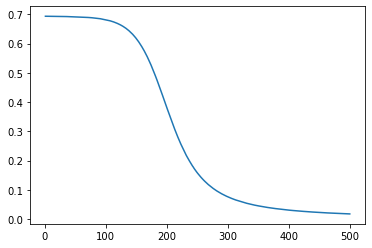

In [54]:
plt.plot(list(range(1, len(d["cost"]) + 1)), d['cost'])

In [69]:
# Set structure for neural net
n_x = X_train.shape[0]
layer_dims = [n_x, 32, 4, 1]

d = NN_model(X_dev, y_dev, layer_dims, batch_size=64, learning_rate=0.01, nr_iter = 1000)

Cost on iteration 1: 0.6932
Cost on iteration 100: 0.6923
Cost on iteration 200: 0.0010
Cost on iteration 300: 0.0003
Cost on iteration 400: 0.0002
Cost on iteration 500: 0.0001
Cost on iteration 600: 0.0001
Cost on iteration 700: 0.0001
Cost on iteration 800: 0.0001
Cost on iteration 900: 0.0001
Cost on iteration 1000: 0.0000
Finished.


In [70]:
preds_train = predict_deep(X_train, y_train, d["parameters"])
print("Accuracy on train set: " + str(100 - np.mean(np.abs(preds_train-y_train)) * 100))

Accuracy on train set: 100.0


In [71]:
preds_dev = predict_deep(X_dev, y_dev, d["parameters"])
print("Accuracy on dev set: " + str(100 - np.mean(np.abs(preds_dev-y_dev)) * 100))

Accuracy on dev set: 100.0


In [72]:
preds_test = predict_deep(X_test, y_test, d["parameters"])
print("Accuracy on test set: " + str(100 - np.mean(np.abs(preds_test-y_test)) * 100))

Accuracy on test set: 100.0


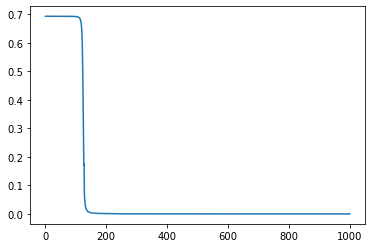

In [73]:
plt.plot(list(range(1, len(d["cost"]) + 1)), d['cost'])

In [55]:
# Let's do everything that we have done, but now with tensorflow.

In [75]:
model = keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [76]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(X_train.T, y_train.T, epochs = 1000, verbose=False)

In [ ]:
dev_loss, dev_acc = model.evaluate(X_dev.T, y_dev.T, verbose=2)

print("\n Dev accuracy: ", dev_acc)